# Load Data

In [1]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

2025-02-03 14:30:17.657161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 14:30:18.104085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738618218.219598   27303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738618218.258816   27303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 14:30:18.584394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Prep

In [2]:
import numpy as np

# Subset your data the same 3 digit classes you used in the last assignments.

# Again, You can totally copy any code over and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objectives and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data

train_filter = (y_train == 5) | (y_train == 6) | (y_train == 8)
x_train_nn = x_train[train_filter]
y_train_nn = y_train[train_filter]

# Extract the 3 classes from the test data

test_filter = (y_test == 5) | (y_test == 6) | (y_test == 8)
x_test_nn = x_test[test_filter]
y_test_nn = y_test[test_filter]

print(y_train_nn)
y_train_nn_bin = np.array([0 if y == 5 else (1 if y == 6 else 2) for y in y_train_nn])
y_test_nn_bin = np.array([0 if y == 5 else (1 if y == 6 else 2) for y in y_test_nn])
print(y_train_nn_bin)

[5 5 6 ... 5 6 8]
[0 0 1 ... 0 1 2]


## Plot Data

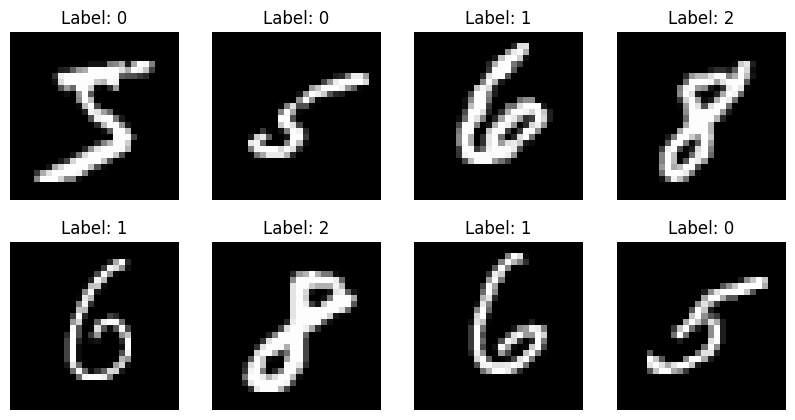

In [3]:
## Plot 6 to 10 images from your data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_nn[i], cmap='gray')
    plt.title(f'Label: {y_train_nn_bin[i]}')
    plt.axis('off')

plt.show()

# Transfer Learning

## Load and Modify Model

In [4]:
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load and modify a pre-trained mobilenet_v2 model for your dataset
# Make sure to change the output layer for the number of classes you are using

# Load pre-trained MobileNetV2
model = mobilenet_v2(pretrained=True)

# Modify the input layer for grayscale (1 channel)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)

# Modify the output layer for your dataset's number of classes
model.classifier[1] = nn.Linear(model.last_channel, 3)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

/home/hfluke/anaconda3/envs/rapids/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hfluke/anaconda3/envs/rapids/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Modify Data to fit with Model

In [5]:
import torchvision.transforms as transforms
import torch

# Pre-trained models may not match the structure of our data.
# It's best to modify the model to handle the data, but we may need to adjust the images as well.
# Resize the images to 32x32 for the model

# Define the transform to resize the images
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Apply the transform to the training and test datasets
x_train_nn_resized = torch.stack([resize_transform(img) for img in x_train_nn])
x_test_nn_resized = torch.stack([resize_transform(img) for img in x_test_nn])

print(f'x_train_nn_resized shape: {x_train_nn_resized.shape}')
print(f'x_test_nn_resized shape: {x_test_nn_resized.shape}')

x_train_nn_resized shape: torch.Size([17190, 1, 32, 32])
x_test_nn_resized shape: torch.Size([2824, 1, 32, 32])


## Fit Model on our Data

In [6]:
import torch
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Convert your data to tensors and create a DataLoader

# Create Tensors and DataLoader for resized training and testing data
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long)

train_dataset_resized = TensorDataset(x_train_nn_resized, y_train_tensor)
test_dataset_resized = TensorDataset(x_test_nn_resized, y_test_tensor)
train_loader_resized = DataLoader(train_dataset_resized, batch_size=64, shuffle=True)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=64, shuffle=False)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Update your model with our training data
# Report some notion of accuracy, loss or both as it builds to see how well your model is doing.

# Train the model on resized data
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_resized:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader_resized)}')

# Evaluate the model on resized test data
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader_resized:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader_resized)
    avg_val_loss = val_loss / len(test_loader_resized)
    val_accuracy = correct / total
        
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
        f'Train Loss: {avg_train_loss:.4f}, '
        f'Validation Loss: {avg_val_loss:.4f}, '
        f'Validation Accuracy: {val_accuracy:.4f}')

print(f'Test Accuracy on resized data: {100 * correct / total}%')

Epoch 1/10, Train Loss: 0.1137, Validation Loss: 0.0255, Validation Accuracy: 0.9929
Epoch 2/10, Train Loss: 0.0379, Validation Loss: 0.0215, Validation Accuracy: 0.9943
Epoch 3/10, Train Loss: 0.0275, Validation Loss: 0.0285, Validation Accuracy: 0.9873
Epoch 4/10, Train Loss: 0.0176, Validation Loss: 0.0218, Validation Accuracy: 0.9926
Epoch 5/10, Train Loss: 0.0335, Validation Loss: 0.0171, Validation Accuracy: 0.9940
Epoch 6/10, Train Loss: 0.0184, Validation Loss: 0.0613, Validation Accuracy: 0.9837
Epoch 7/10, Train Loss: 0.0175, Validation Loss: 0.0190, Validation Accuracy: 0.9947
Epoch 8/10, Train Loss: 0.0102, Validation Loss: 0.0131, Validation Accuracy: 0.9965
Epoch 9/10, Train Loss: 0.0086, Validation Loss: 0.0195, Validation Accuracy: 0.9961
Epoch 10/10, Train Loss: 0.0100, Validation Loss: 0.0119, Validation Accuracy: 0.9968
Test Accuracy on resized data: 99.6813031161473%


## Confusion Matrix

[0 1 0 ... 2 0 1]


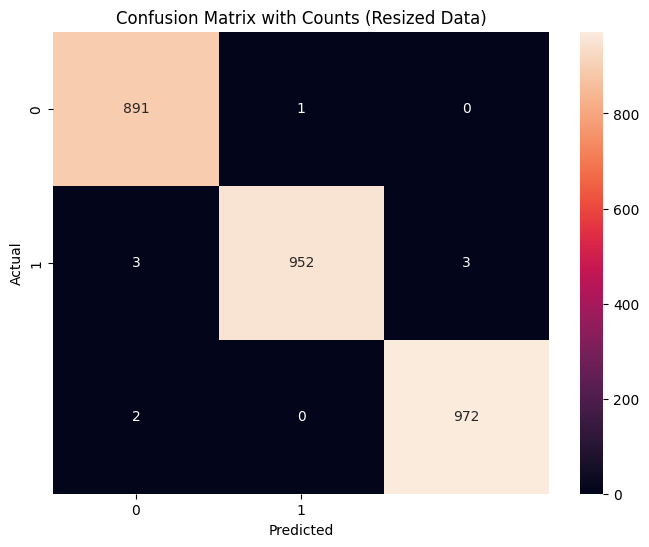

The model struggled the most with predicting 6's


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute and plot a confusion matrix.

# Set the model to evaluation mode
model.eval()

# Make predictions on the resized test set
with torch.no_grad():
    outputs_resized = model(x_test_nn_resized)
    _, predicted_resized = torch.max(outputs_resized, 1)

# Convert predictions to numpy array
predicted_resized = predicted_resized.numpy()

print(predicted_resized)

# Compute the confusion matrix
conf_matrix_resized = confusion_matrix(y_test_nn_bin, predicted_resized)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resized, annot=True, fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (Resized Data)')
plt.show()

# Where are misclassifications occurring?
# How does your test accuracy compare to that of the Random Forest and CNN made previously?
# It's very possible that it won't be better than the CNN.
# This hopefully illustrates the importance of choosing the right kind of model to transfer learn from.

print("The model struggled the most with predicting 6's")

## Plot Misclassifications

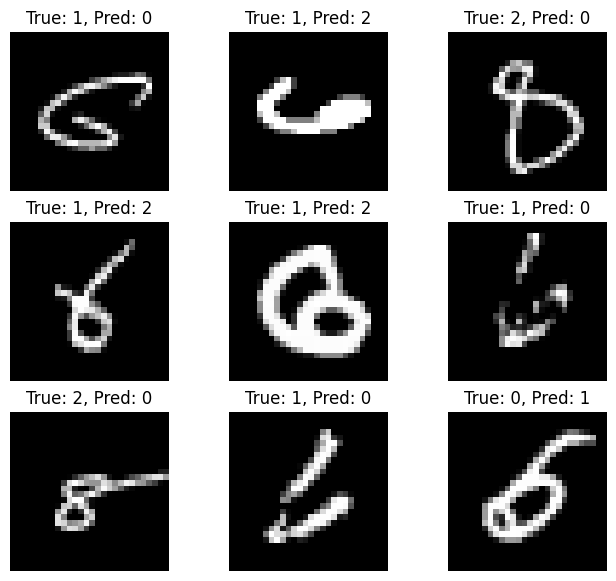

Some of the misclassified images would be difficult to predict without ML.


In [14]:
import matplotlib.pyplot as plt

# Plot some of the misclassifications.

# Find misclassified examples
misclassified_indices = (predicted_resized != y_test_nn_bin).nonzero()[0]

# Plot some misclassified examples
plt.figure(figsize=(8, 7))

for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_nn[idx], cmap='gray')
    plt.title(f'True: {y_test_nn_bin[idx]}, Pred: {predicted_resized[idx]}')
    plt.axis('off')

plt.show()

# Can you see why the model made the misclassifications it did?

print("Some of the misclassified images would be difficult to predict without ML.")